# Project 3: Parsing and Transformers

This project covers constituency parsing and the Transformer neural network architecture.  First, you will implement a Transformer encoder, using a part-of-speech tagging task as an initial test of your implementation.  Then, you will implement a Transformer-based constituency parser.  Your parser will be trained to classify span labels, then you will implement the CKY algorithm to turn the predictions into trees.



## Setup

The dependencies for this project include:
* `torch` for modeling and training
* `sentencepiece` for subword tokenization
* `nltk` for loading and working with parse tree data structures
* `svgling` for rendering parse trees in the browser

In [1]:
%%capture
!pip install --upgrade nltk sentencepiece svgling tqdm

# Standard library imports
from copy import deepcopy
import json
import math
import random

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import sentencepiece
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import tqdm.notebook

import nltk
from nltk.corpus.reader.bracket_parse import BracketParseCorpusReader

import svgling
svgling.disable_nltk_png()

Before proceeding, let's verify that we're connected to a GPU runtime and that `torch` can detect the GPU.
We'll define a variable `device` here to use throughout the code so that we can easily change to run on CPU for debugging.

In [2]:
assert torch.cuda.is_available()
device = torch.device("cuda")
print("Using device:", device)

Using device: cuda


## Data

The code below downloads the standard Penn Treebank data splits for parsing: sections 2-21 are used for training, section 22 for validation, and section 23 for testing. For consistency, we'll use these same splits for part-of-speech tagging, but we should note that most academic papers use a different way of splitting up the Penn Treebank data for the part-of-speech tagging task.

In [3]:
%%bash
if [ ! -e parsing-data.zip ]; then
  wget --quiet https://storage.googleapis.com/cs288-parsing-project/parsing-data.zip
fi
rm -rf train dev test EVALB/
unzip parsing-data.zip

Archive:  parsing-data.zip
  inflating: train                   
  inflating: dev                     
  inflating: test                    
   creating: EVALB/
  inflating: EVALB/.DS_Store         
   creating: EVALB/bug/
  inflating: EVALB/bug/bug.gld       
  inflating: EVALB/bug/bug.rsl-new   
  inflating: EVALB/bug/bug.rsl-old   
  inflating: EVALB/bug/bug.tst       
  inflating: EVALB/COLLINS.prm       
  inflating: EVALB/evalb.c           
  inflating: EVALB/LICENSE           
  inflating: EVALB/Makefile          
  inflating: EVALB/new.prm           
  inflating: EVALB/nk.prm            
  inflating: EVALB/README            
   creating: EVALB/sample/
  inflating: EVALB/sample/sample.gld  
  inflating: EVALB/sample/sample.prm  
  inflating: EVALB/sample/sample.rsl  
  inflating: EVALB/sample/sample.tst  
  inflating: EVALB/tgrep_proc.prl    


Let's take a look at the format of the data:

In [4]:
!head -n 2 train

(TOP (S (PP (IN In) (NP (NP (DT an) (NNP Oct.) (CD 19) (NN review)) (PP (IN of) (NP (`` ``) (NP (DT The) (NN Misanthrope)) ('' '') (PP (IN at) (NP (NP (NNP Chicago) (POS 's)) (NNP Goodman) (NNP Theatre))))) (PRN (-LRB- -LRB-) (`` ``) (S (NP (VBN Revitalized) (NNS Classics)) (VP (VBP Take) (NP (DT the) (NN Stage)) (PP (IN in) (NP (NNP Windy) (NNP City))))) (, ,) ('' '') (NP (NN Leisure) (CC &) (NNS Arts)) (-RRB- -RRB-)))) (, ,) (NP (NP (NP (DT the) (NN role)) (PP (IN of) (NP (NNP Celimene)))) (, ,) (VP (VBN played) (PP (IN by) (NP (NNP Kim) (NNP Cattrall)))) (, ,)) (VP (VBD was) (VP (ADVP (RB mistakenly)) (VBN attributed) (PP (TO to) (NP (NNP Christina) (NNP Haag))))) (. .)))
(TOP (S (NP (NNP Ms.) (NNP Haag)) (VP (VBZ plays) (NP (NNP Elianti))) (. .)))


The files include one tree per line. We'll use the `BracketParseCorpusReader` from `nltk` to load the data.

In [5]:
READER = BracketParseCorpusReader('.', ['train', 'dev', 'test'])

## Vocabulary

We first extract the sentences alone from the data and construct a subword vocabulary, much like in Project 2. We use a subword vocabulary because it allows us to largely avoid the issue of having unknown words at test time.

In [6]:
READER.sents('train')[1]

['Ms.', 'Haag', 'plays', 'Elianti', '.']

In [7]:
with open('sentences.txt', 'w') as f:
  for sent in READER.sents('train'):
    f.write(' '.join(sent) + '\n')

In [8]:
!head -n 2 sentences.txt

In an Oct. 19 review of `` The Misanthrope '' at Chicago 's Goodman Theatre -LRB- `` Revitalized Classics Take the Stage in Windy City , '' Leisure & Arts -RRB- , the role of Celimene , played by Kim Cattrall , was mistakenly attributed to Christina Haag .
Ms. Haag plays Elianti .


In [9]:
args = {
    "pad_id": 0,
    "bos_id": 1,
    "eos_id": 2,
    "unk_id": 3,
    "input": "sentences.txt",
    "vocab_size": 16000,
    "model_prefix": "ptb",
}
combined_args = " ".join(
    "--{}={}".format(key, value) for key, value in args.items())
sentencepiece.SentencePieceTrainer.Train(combined_args)

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3 --input=sentences.txt --vocab_size=16000 --model_prefix=ptb
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: sentences.txt
  input_format: 
  model_prefix: ptb
  model_type: UNIGRAM
  vocab_size: 16000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1

In [10]:
!head -n 10 ptb.vocab

<pad>	0
<s>	0
</s>	0
<unk>	0
s	-2.85521
▁,	-3.27876
▁the	-3.38611
▁.	-3.51129
▁	-3.69929
▁to	-4.02176


In [11]:
VOCAB = sentencepiece.SentencePieceProcessor()
VOCAB.Load("ptb.model")

True

We define some constants here for special tokens that you may find useful in the following sections.

In [12]:
PAD_ID = VOCAB.PieceToId("<pad>")
BOS_ID = VOCAB.PieceToId("<s>")
EOS_ID = VOCAB.PieceToId("</s>")
UNK_ID = VOCAB.PieceToId("<unk>")

## Part-of-Speech Tagging: Task Setup

We will now begin preparing for the part-of-speech tagging task.  In this task, we will label each word token in a sentence or corpus with a part-of-speech tag.  Note the difference between operating over word tokens in a corpus and HW1 where we operated over unique word types.  In this setup, we may see each word type many times, and we also take the context where it appears into account.

For this task we provide you with all of the data processing code, while you will implement the model using the Transformer architecture. However, please take note of the input pipeline here because you will need to implement your own data processing for the second half of the project.

Although we would like to use a subword vocabulary to better handle rare words, the part-of-speech and parsing tasks are defined in terms of words, not subwords.  After encoding a sentence at the subword level with an encoder (LSTM or Transformer), we will then move to the word level by selecting a single representation per word.  In the `encode_sentence` function below, we will create a boolean mask to select from the last subword of every word.  Tagging decisions will be made based on the vector associated with this last subword. (You may modify this to, for example, use the first word piece instead, though that seems to perform slightly worse at least for the baseline model.)

In [13]:
def encode_sentence(sent):
  """Prepares a sentence for input to the model, including subword tokenization.

  Args:
    sent: a list of words (each word is a string)
  Returns:
    A tuple (ids, is_word_end).
      ids: a list of token ids in the subword vocabulary
      is_word_end: a list with elements of type bool, where True indicates that
                   the word piece at that position is the last within its word.
  """
  ids = []
  is_word_end = []
  for word in sent:
    word_ids = VOCAB.EncodeAsIds(word)
    ids.extend(word_ids)
    is_word_end.extend([False] * (len(word_ids) - 1) + [True])
  return ids, is_word_end

In [14]:
print("Vocabulary size:", VOCAB.GetPieceSize())
print()

for sent in READER.sents('train')[:2]:
  indices, is_word_end = encode_sentence(sent)
  pieces = [VOCAB.IdToPiece(index) for index in indices]
  print(sent)
  print(pieces)
  print(is_word_end)
  print(VOCAB.DecodePieces(pieces))
  print(indices)
  print(VOCAB.DecodeIds(indices))
  print()

Vocabulary size: 16000

['In', 'an', 'Oct.', '19', 'review', 'of', '``', 'The', 'Misanthrope', "''", 'at', 'Chicago', "'s", 'Goodman', 'Theatre', '-LRB-', '``', 'Revitalized', 'Classics', 'Take', 'the', 'Stage', 'in', 'Windy', 'City', ',', "''", 'Leisure', '&', 'Arts', '-RRB-', ',', 'the', 'role', 'of', 'Celimene', ',', 'played', 'by', 'Kim', 'Cattrall', ',', 'was', 'mistakenly', 'attributed', 'to', 'Christina', 'Haag', '.']
['▁In', '▁an', '▁Oct', '.', '▁19', '▁review', '▁of', '▁``', '▁The', '▁Mi', 's', 'anthrop', 'e', "▁''", '▁at', '▁Chicago', "▁'", 's', '▁Good', 'man', '▁The', 'at', 're', '▁-', 'L', 'RB', '-', '▁``', '▁Rev', 'ital', 'ized', '▁Classic', 's', '▁Take', '▁the', '▁St', 'age', '▁in', '▁Wind', 'y', '▁City', '▁,', "▁''", '▁L', 'eisure', '▁', '&', '▁Art', 's', '▁-', 'R', 'RB', '-', '▁,', '▁the', '▁role', '▁of', '▁Cel', 'imene', '▁,', '▁play', 'ed', '▁by', '▁Kim', '▁Ca', 't', 't', 'rall', '▁,', '▁was', '▁mistaken', 'ly', '▁attribute', 'd', '▁to', '▁Christin', 'a', '▁Haag', '▁.

Now we turn our attention to the desired output from the model, namely a sequence of part of speech tags. The `READER` object from NLTK has a method for returing word-and-tag tuples read from the data.

In [15]:
READER.tagged_sents('train')[1]

[('Ms.', 'NNP'),
 ('Haag', 'NNP'),
 ('plays', 'VBZ'),
 ('Elianti', 'NNP'),
 ('.', '.')]

Running the cell below will print a definition and some examples for each part-of-speech class.

In [16]:
nltk.download('tagsets_json')
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

We construct a part of speech tag vocabulary by iterating over all tags in the training data. Note that opening parentheses `(` are escaped as `-LRB-` in the data format (and similarly `)` is escaped as `-RRB-`)

In [17]:
def get_pos_vocab():
  all_pos = set()
  for sent in READER.tagged_sents('train'):
    for word, pos in sent:
      all_pos.add(pos)
  return sorted(all_pos)

PARTS_OF_SPEECH = get_pos_vocab()
print(PARTS_OF_SPEECH)

['#', '$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


The `POSTaggingDataset` object defined below is a PyTorch Dataset object for this task.

Each example in the dataset is a feature dictionary, consisting of word piece `ids`, and corresponding label ids (`labels`). We associate a word's label with the last subword. Any remaining subwords, as well as special tokens like the start token or padding token, will have a label of -1 assigned to them. This will signal that we shouldn't compute a loss for that label.

We also define a `collate` function that takes care of padding when examples are batched together. 

In [18]:
class POSTaggingDataset(torch.utils.data.Dataset):
  def __init__(self, split):
    assert split in ('train', 'dev', 'test')
    self.sents = READER.tagged_sents(split)
    if split == 'train':
      # To speed up training, we only train on short sentences.
      self.sents = [sent for sent in self.sents if len(sent) <= 40]

  def __len__(self):
    return len(self.sents)

  def __getitem__(self, index):
    sent = self.sents[index]
    ids, is_word_end = encode_sentence([word for word, pos in sent])
    ids = [BOS_ID] + ids + [EOS_ID]
    is_word_end = [False] + is_word_end + [False]
    ids = torch.tensor(ids)
    is_word_end = torch.tensor(is_word_end)
    labels = torch.full_like(ids, -1)
    labels[is_word_end] = torch.tensor(
        [PARTS_OF_SPEECH.index(pos) for word, pos in sent])
    return {'ids': ids, 'labels': labels}

  @staticmethod
  def collate(batch):
    ids = pad_sequence(
        [item['ids'] for item in batch],
        batch_first=True, padding_value=PAD_ID)
    labels = pad_sequence(
        [item['labels'] for item in batch],
        batch_first=True, padding_value=-1)
    return {'ids': ids.to(device), 'labels': labels.to(device)}

In [19]:
dataset_for_inspection = POSTaggingDataset('train')
datum = dataset_for_inspection[0]
datum

{'ids': tensor([   1,  126,    4,   14, 9343,  711,    4, 4388, 8356,    7,    2]),
 'labels': tensor([-1, -1, -1, 20, 20, -1, 39, -1, 20,  6, -1])}

In [20]:
for i, (piece_id, label) in enumerate(zip(datum['ids'].tolist(),
                                          datum['labels'].tolist())):
  print('{:2d} {: <5} {}'.format(
      i, "-" if label == -1 else PARTS_OF_SPEECH[label],
      VOCAB.IdToPiece(piece_id)))

 0 -     <s>
 1 -     ▁M
 2 -     s
 3 NNP   .
 4 NNP   ▁Haag
 5 -     ▁play
 6 VBZ   s
 7 -     ▁Eli
 8 NNP   anti
 9 .     ▁.
10 -     </s>


In [21]:
data_loader_for_inspection = torch.utils.data.DataLoader(
    dataset_for_inspection, batch_size=2, shuffle=True,
    collate_fn=dataset_for_inspection.collate)
next(iter(data_loader_for_inspection))

{'ids': tensor([[   1,  124, 2232,   12,  632,  635,   42,   10,   28,  431,   18, 4292,
           604,    4,    9, 1629,    6,   98,   40,   45, 4292,   84,    7,   30,
             2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0],
         [   1,   28,  204,   20,  262,    8, 1199,   11,  676,    9,  943,   59,
            92,   61,   19,   69,   14,   65,   14,    7,   59,   90,   61,   19,
           603,   15,   11,  676,   73,   51,   26,    8, 1199,    5,   30,   39,
            14, 2291,   32,   13,    7,    2]], device='cuda:0'),
 'labels': tensor([[-1, 25, -1, 35, 20, -1, 20, 13, 44, -1, 36, 14, -1, 22, 32, 34, 10, 19,
          13, 10, 14, 19,  6,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1],
         [-1, 44, 25, -1, 38, -1, 37, 10, 19, 32, 34, -1, -1, -1,  4, -1, -1, -1,
          20,  6, -1, -1, -1,  5, 22,  8, 10, 19, 15, 18, 34, -1, 37,  3,  2, -1,
          20, 2

## Training Loop and Baseline POS Tagging Model

Now it's time to build a model. At a high level, the model will encode the sentence using a Transformer architecture, then project to a softmax over the vocabulary at each word position.  We've implemented the overall model framework already, including computing the softmax cross-entropy loss for training the tagger.

In [22]:
class POSTaggingModel(nn.Module):
  def encode(self, batch):
    # you will override this function in a subclass below
    raise NotImplementedError()

  def compute_loss(self, batch):
    logits = self.encode(batch)
    logits = logits.reshape((-1, logits.shape[-1]))
    labels = batch['labels'].reshape((-1,))
    res = F.cross_entropy(logits, labels, ignore_index=-1, reduction='mean')
    return res
  
  def get_validation_metric(self, batch_size=8):
    dataset = POSTaggingDataset('dev')
    data_loader = torch.utils.data.DataLoader(
      dataset, batch_size=batch_size, collate_fn=dataset.collate)
    self.eval()
    correct = 0
    total = 0
    with torch.no_grad():
      for batch in data_loader:
        mask = (batch['labels'] != -1)
        predicted_labels = self.encode(batch).argmax(-1)
        predicted_labels = predicted_labels[mask]
        gold_labels = batch['labels'][mask]
        correct += (predicted_labels == gold_labels).sum().item()
        total += gold_labels.shape[0]
    return correct / total

We define the following functions for training.  This code will run as provided, but you are welcome to modify the training loop to adjust the optimizer settings, modify the learning rate schedule, etc.

When training transformers, it has been found that early training can be unstable unless the learning rate starts out very low.  To alleviate this instability, we'll use a schedule where the learning rate is increased linearly from 0 to its maximum value during a warm-up phase, and is then decayed as training progresses.

You may change the duration of the warmup phase or disable it entirely, but bear in mind that warmup is generally seen as a key ingredient for stably training Transformer models. 

In [23]:
def train(model, num_epochs, batch_size, model_file,
          learning_rate=8e-4, dataset_cls=POSTaggingDataset):
  """Train the model and save its best checkpoint.
  
  Model performance across epochs is evaluated on the validation set. The best
  checkpoint obtained during training will be stored on disk and loaded back
  into the model at the end of training.
  """
  dataset = dataset_cls('train')
  data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, collate_fn=dataset.collate)
  optimizer = torch.optim.Adam(
      model.parameters(),
      lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(
      optimizer,
      learning_rate,
      epochs=num_epochs,
      steps_per_epoch=len(data_loader),
      pct_start=0.02,  # Warm up for 2% of the total training time
      )
  best_metric = 0.0
  for epoch in tqdm.notebook.trange(num_epochs, desc="training", unit="epoch"):
    with tqdm.notebook.tqdm(
        data_loader,
        desc="epoch {}".format(epoch + 1),
        unit="batch",
        total=len(data_loader)) as batch_iterator:
      model.train()
      total_loss = 0.0
      for i, batch in enumerate(batch_iterator, start=1):
        optimizer.zero_grad()
        loss = model.compute_loss(batch)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        batch_iterator.set_postfix(mean_loss=total_loss / i)
      validation_metric = model.get_validation_metric()
      batch_iterator.set_postfix(
          mean_loss=total_loss / i,
          validation_metric=validation_metric)
      if validation_metric > best_metric:
        print(
            "Obtained a new best validation metric of {:.3f}, saving model "
            "checkpoint to {}...".format(validation_metric, model_file))
        torch.save(model.state_dict(), model_file)
        best_metric = validation_metric
  print("Reloading best model checkpoint from {}...".format(model_file))
  model.load_state_dict(torch.load(model_file))

We can now train a very simple baseline model that learns a single parameter per part of speech tag.

A classifier where each word is assigned its most-frequent tag from the training data (and unknown words are treated as nouns) has 92.2% validation accuracy with our current splits. However, with our subword vocabulary (and taking the last subword as representative of each word), the accuracy is instead 87.6%. The `BaselineModel` should achieve roughly this accuracy.

In [24]:
class BaselineModel(POSTaggingModel):
  def __init__(self):
    super().__init__()
    self.lookup = nn.Embedding(VOCAB.GetPieceSize(), len(PARTS_OF_SPEECH))

  def encode(self, batch):
    ids = batch['ids']
    return self.lookup(ids)

In [25]:
baseline_model = BaselineModel().to(device)
#train(baseline_model, num_epochs=5, batch_size=64,
#      model_file="baseline_model.pt", learning_rate=0.1)

Having trained the model, we can examine its predictions on an example from the validation set.

In [26]:
def predict_tags(tagging_model, split, limit=None):
  assert split in ('dev', 'test')
  sents = READER.sents(split)
  dataset = POSTaggingDataset(split)
  data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=False, collate_fn=dataset.collate)
  tagging_model.eval()
  pred_tagged_sents = []
  with torch.no_grad():
    for batch in data_loader:
      mask = (batch['labels'] != -1)
      predicted_labels = tagging_model.encode(batch).argmax(-1)
      for i in range(batch['ids'].shape[0]):
        example_predicted_tags = [
            PARTS_OF_SPEECH[label] for label in predicted_labels[i][mask[i]]]
        sent = sents[len(pred_tagged_sents)]
        assert len(sent) == len(example_predicted_tags)
        pred_tagged_sents.append(list(zip(sent, example_predicted_tags)))
        if limit is not None and len(pred_tagged_sents) >= limit:
          return pred_tagged_sents
  return pred_tagged_sents

In [27]:
predict_tags(baseline_model, 'dev', limit=1)

[[('Influential', '#'),
  ('members', '-RRB-'),
  ('of', 'MD'),
  ('the', 'NNP'),
  ('House', 'VBP'),
  ('Ways', ','),
  ('and', 'WDT'),
  ('Means', ','),
  ('Committee', 'WP'),
  ('introduced', 'PDT'),
  ('legislation', '.'),
  ('that', 'IN'),
  ('would', 'SYM'),
  ('restrict', 'POS'),
  ('how', 'NN'),
  ('the', 'NNP'),
  ('new', 'VBN'),
  ('savings-and-loan', '#'),
  ('bailout', 'PRP$'),
  ('agency', 'FW'),
  ('can', '$'),
  ('raise', 'EX'),
  ('capital', 'VB'),
  (',', '-RRB-'),
  ('creating', 'VBN'),
  ('another', 'WP$'),
  ('potential', 'CC'),
  ('obstacle', 'VBZ'),
  ('to', ','),
  ('the', 'NNP'),
  ('government', 'JJS'),
  ("'s", ','),
  ('sale', 'VBZ'),
  ('of', 'MD'),
  ('sick', '#'),
  ('thrifts', ','),
  ('.', '$')]]

## Transformer POS Tagging Model

Your task is to implement the Transformer architecture (https://arxiv.org/pdf/1706.03762.pdf) and apply it to tagging.

Here is a diagram of the architecture you will implement:

<img src="https://www.researchgate.net/publication/334288604/figure/fig1/AS:778232232148992@1562556431066/The-Transformer-encoder-structure.ppm" width="180em">

This portion is referred to as the "Transformer Encoder". In the paper there is also a decoder portion for generating text one token at a time; such a decoder is not needed for this project.

The key elements of the Transformer are a multi-headed attention mechanism, and a feed-forward layer.

Each sub-layer (whether multi-head attention of feed forward) uses a residual connection followed by Layer Normalization (`nn.LayerNorm` in pytorch). Both residual connections and normalizations are crucial to being able to train a model that's more than a couple layers deep.


The first part is multi-head self-attention. In this layer, you will need to:
- Apply linear projections to convert the feature vector at each token into separate vectors for the query, key, and value.
- Apply attention, scaling the logits by $\frac{1}{sqrt(d_{qkv})}$.
- Ensure proper masking, such that padding tokens are never attended to.
- Perform attention `n_head` times in parallel, where the results are concatenated and then projected using a linear layer.

<img src="https://www.researchgate.net/publication/332139525/figure/fig3/AS:743081083158528@1554175744311/a-The-Transformer-model-architecture-b-left-Scaled-Dot-Product-Attention.ppm" width="360em">

You should include two types of dropout in your code (with probability set by the  `dropout` argument):
- Dropout should be applied to the output of the attention layer (just prior to the residual connection, denoted by "Add & Norm" in the first figure)
- Dropout should *also* be applied to attention probabilites, right after the softmax operation that's applied to query-key dot products. This type of dropout stochastically prevents a query position from attending to a fraction of key positions, which can help generalization. (Note that the probabilities will no longer sum to 1, but that's okay - they will still have an expectation of 1 due to PyTorch's dropout rescaling)

Notes:
- Query, key, and value vectors should have shape `[batch_size, n_heads, sequence_len, d_qkv]`
- Attention logits and probabilities should have shape `[batch_size, n_heads, sequence_len, sequence_len]`
- Vaswani et al. define the output of the attention layer as concatenating the various heads and then multiplying by a matrix $W^O$. It's also possible to implement this is a sum without ever calling `torch.cat`: note that $\text{Concat}(head_1, \ldots, head_h)W^O = head_1 W^O_1 + \ldots + head_h W^O_h$ where $W^O = \begin{bmatrix} W^O_1\\ \vdots\\ W^O_h\end{bmatrix}$

In [28]:
import pdb

class MultiHeadAttention(nn.Module):
  def __init__(self, d_model=256, n_head=4, d_qkv=32, dropout=0.1, **kwargs):
    super().__init__()
    self.d_model = d_model
    self.n_head = n_head
    self.d_qkv = d_qkv

    # We provide these model parameters to give an example of a weight
    # initialization approach that we know works well for our tasks. Feel free
    # to delete these lines and write your own, if you would like.
    self.w_q = nn.Parameter(torch.Tensor(n_head, d_model, d_qkv))
    self.w_k = nn.Parameter(torch.Tensor(n_head, d_model, d_qkv))
    self.w_v = nn.Parameter(torch.Tensor(n_head, d_model, d_qkv))
    self.w_o = nn.Parameter(torch.Tensor(n_head, d_qkv, d_model))
    nn.init.xavier_normal_(self.w_q)
    nn.init.xavier_normal_(self.w_k)
    nn.init.xavier_normal_(self.w_v)
    nn.init.xavier_normal_(self.w_o)

    # The hyperparameters given as arguments to this function and others
    # should be sufficient to reach the score targets for this project

    """YOUR CODE HERE"""

    # BEGIN SOLUTION
    self.dropout = nn.Dropout(dropout)
    self.layer_norm = nn.LayerNorm(d_model)
    # END SOLUTION
  
  def forward(self, x, mask):
    """Runs the multi-head self-attention layer.

    Args:
      x: the input to the layer, a tensor of shape [batch size, length, d_model]
      mask: a mask for disallowing attention to padding tokens. You will need to
            construct the mask yourself further on in this notebook. You may
            implement masking in any way; there is no requirement that you use
            a particular form for the mask object.
    Returns:
      A single tensor containing the output from this layer
    """
    """YOUR CODE HERE"""
    # Implementation tip: using torch.einsum will greatly simplify the code that
    # you need to write.

    # BEGIN SOLUTION
    query = torch.einsum("blj,njk->bnlk", x, self.w_q)
    key = torch.einsum("blj,njk->bnlk", x, self.w_k)
    value = torch.einsum("blj,njk->bnlk", x, self.w_v)
    qk=torch.matmul(query,key.permute(0,1,3,2))
    qk/=math.sqrt(self.d_qkv)
    qk -= 1e9 * mask[:, None, None, :] 
    qk = F.softmax(qk,dim=-1)
    qk = self.dropout(qk)
    qkv = torch.einsum("bnlj,bnjk->bnlk",qk,value)
    output = torch.einsum("bnlk,nkd->bld",qkv,self.w_o)
    output=self.dropout(output)
    output=self.layer_norm(output+x)
    return output
    # END SOLUTIOIN

The other component is the position-wise feed forward layer. This layer's architecture is sometimes called dense-relu-dense, because it consists of two dense linear layers with ReLU nonlinearity in the middle. The dropout here is typically applied at the output of the layer instead of next to the non-linearity in the middle.

In [29]:
class PositionwiseFeedForward(nn.Module):
  def __init__(self, d_model, d_ff, dropout=0.1):
    super().__init__()
    """YOUR CODE HERE"""

    # BEGIN SOLUTION
    self.fc1 = nn.Linear(d_model, d_ff)
    self.fc2 = nn.Linear(d_ff, d_model)
    self.relu =  nn.LeakyReLU(0.2)
    self.dropout=nn.Dropout(dropout)
    self.layer_norm=nn.LayerNorm(d_model)
    # END SOLUTION

  def forward(self, x):
    """YOUR CODE HERE"""

    # BEGIN SOLUTION
    output=self.fc1(x)
    output=self.relu(output)
    output=self.fc2(output)
    output=self.dropout(output)
    output=self.layer_norm(x+output)
    return output
    # END SOLUTION

Combining the two gives the full transformer encoder architecture.

In [30]:
class TransformerEncoder(nn.Module):
  def __init__(self, d_model=256, d_ff=1024, n_layers=4, n_head=4, d_qkv=32,
               dropout=0.1):
    super().__init__()
    # Implementation tip: if you are storing nn.Module objects in a list, use
    # nn.ModuleList. If you use assignment statements of the form
    # `self.sublayers = [x, y, z]` with a plain python list instead of a
    # ModuleList, you might find that none of the sub-layer parameters are
    # trained.

    """YOUR CODE HERE"""

    # BEGIN SOLUTION
    self.n_layers=n_layers
    self.multi_head=nn.ModuleList([MultiHeadAttention(d_model, n_head, d_qkv, dropout)]*n_layers)
    self.position_wise=nn.ModuleList([ PositionwiseFeedForward(d_model,d_ff,dropout)]*n_layers)
    # END SOLUTION

  def forward(self, x, mask):
    """Runs the Transformer encoder.

    Args:
      x: the input to the Transformer, a tensor of shape
         [batch size, length, d_model]
      mask: a mask for disallowing attention to padding tokens. You will need to
            construct the mask yourself further on in this notebook. You may
            implement masking in any way; there is no requirement that you use
            a particular form for the mask object.
    Returns:
      A single tensor containing the output from the Transformer
    """

    """YOUR CODE HERE"""

    # BEGIN SOLUTION
    for i in range(self.n_layers):
        head=self.multi_head[i]
        pos=self.position_wise[i]
        x=head(x,mask)
        x=pos(x)
    return x
    # END SOLUTION

Unlike with recurrent neural networks, word order is not encoded in the Transformer architecture directly. Instead, positions of words are provided in the form of position embeddings that are added to the feature vector of each word. The exact formulation of the position embeddings tends to be implementation-dependent, and a number of approaches have been proposed in the literature. The `AddPositionalEncoding` class below provides a version of positional encoding, with dropout, that we found to work well for parsing (the second task in this assignment). However, you are allowed to use a different implementation if you would like.

In [31]:
class AddPositionalEncoding(nn.Module):
  def __init__(self, d_model=256, input_dropout=0.1, timing_dropout=0.1,
               max_len=512):
    super().__init__()
    self.timing_table = nn.Parameter(torch.FloatTensor(max_len, d_model))
    nn.init.normal_(self.timing_table)
    self.input_dropout = nn.Dropout(input_dropout)
    self.timing_dropout = nn.Dropout(timing_dropout)
  
  def forward(self, x):
    """
    Args:
      x: A tensor of shape [batch size, length, d_model]
    """
    x = self.input_dropout(x)
    timing = self.timing_table[None, :x.shape[1], :]
    timing = self.timing_dropout(timing)
    return x + timing

Complete the `TransformerPOSTaggingModel` below. Your goal is to achieve a target of 95% accuracy, or higher, on the validation set.

In [32]:
class TransformerPOSTaggingModel(POSTaggingModel):
  def __init__(self):
    super().__init__()
    d_model = 256
    self.add_timing = AddPositionalEncoding(d_model)
    self.encoder = TransformerEncoder(d_model)
    """YOUR CODE HERE."""

    # BEGIN SOLUTION
    self.embed = nn.Embedding(VOCAB.GetPieceSize(), d_model)
    self.fc = nn.Linear(d_model, len(PARTS_OF_SPEECH))
    self.layer_norm=nn.LayerNorm(d_model)
    # END SOLUTION

  def encode(self, batch):
    """
    Args:
      batch: an input batch as a dictionary; the key 'ids' holds the vocab ids
        of the subword tokens in a tensor of size [batch_size, sequence_length]
    Returns:
      A single tensor containing logits for each subword token
        You don't need to filter the unlabeled subwords - this is handled by our
        code above.
    """

    # Implementation tip: you will want to use another normalization layer
    # between the output of the encoder and the final projection layer

    """YOUR CODE HERE."""

    # BEGIN SOLUTION
    vocab_ids=batch['ids'].cuda()
    mask = (vocab_ids == PAD_ID)
    batch_size,seq_len=mask.shape
    embed=self.embed(vocab_ids)
    x=self.add_timing(embed)
    encoder_output = self.encoder(x,mask)
    output = self.fc(encoder_output)
    return output
    # END SOLUTION

In [33]:
# You are welcome to adjust these parameters based on your model implementation.
num_epochs = 8
batch_size = 16

tagging_model = TransformerPOSTaggingModel().to(device)
train(tagging_model, num_epochs, batch_size, "tagging_model.pt")

training:   0%|          | 0/8 [00:00<?, ?epoch/s]

epoch 1:   0%|          | 0/2298 [00:00<?, ?batch/s]

Obtained a new best validation metric of 0.914, saving model checkpoint to tagging_model.pt...


epoch 2:   0%|          | 0/2298 [00:00<?, ?batch/s]

Obtained a new best validation metric of 0.933, saving model checkpoint to tagging_model.pt...


epoch 3:   0%|          | 0/2298 [00:00<?, ?batch/s]

Obtained a new best validation metric of 0.945, saving model checkpoint to tagging_model.pt...


epoch 4:   0%|          | 0/2298 [00:00<?, ?batch/s]

Obtained a new best validation metric of 0.950, saving model checkpoint to tagging_model.pt...


epoch 5:   0%|          | 0/2298 [00:00<?, ?batch/s]

Obtained a new best validation metric of 0.954, saving model checkpoint to tagging_model.pt...


epoch 6:   0%|          | 0/2298 [00:00<?, ?batch/s]

Obtained a new best validation metric of 0.957, saving model checkpoint to tagging_model.pt...


epoch 7:   0%|          | 0/2298 [00:00<?, ?batch/s]

Obtained a new best validation metric of 0.958, saving model checkpoint to tagging_model.pt...


epoch 8:   0%|          | 0/2298 [00:00<?, ?batch/s]

Obtained a new best validation metric of 0.958, saving model checkpoint to tagging_model.pt...
Reloading best model checkpoint from tagging_model.pt...


*You should download the `tagging_model.pt` file now so you can use it for generating submission files below even if your session gets disconnected before you finish.*

In [34]:
predict_tags(tagging_model, 'dev', limit=1)

[[('Influential', 'JJ'),
  ('members', 'NNS'),
  ('of', 'IN'),
  ('the', 'DT'),
  ('House', 'NNP'),
  ('Ways', 'NNPS'),
  ('and', 'CC'),
  ('Means', 'NNPS'),
  ('Committee', 'NNP'),
  ('introduced', 'VBD'),
  ('legislation', 'NN'),
  ('that', 'WDT'),
  ('would', 'MD'),
  ('restrict', 'VB'),
  ('how', 'WRB'),
  ('the', 'DT'),
  ('new', 'JJ'),
  ('savings-and-loan', 'JJ'),
  ('bailout', 'NN'),
  ('agency', 'NN'),
  ('can', 'MD'),
  ('raise', 'VB'),
  ('capital', 'NN'),
  (',', ','),
  ('creating', 'VBG'),
  ('another', 'DT'),
  ('potential', 'JJ'),
  ('obstacle', 'NN'),
  ('to', 'TO'),
  ('the', 'DT'),
  ('government', 'NN'),
  ("'s", 'POS'),
  ('sale', 'NN'),
  ('of', 'IN'),
  ('sick', 'JJ'),
  ('thrifts', 'NNS'),
  ('.', '.')]]

## Parsing: Task Setup

Next, let's move on from predicting tags to predicting full syntax trees. Let's start by taking a look at an example tree and the `nltk.tree.Tree` class.

(TOP
  (S
    (NP (PRP She))
    (VP (VBZ enjoys) (S (VP (VBG playing) (NP (NN tennis)))))
    (. .)))


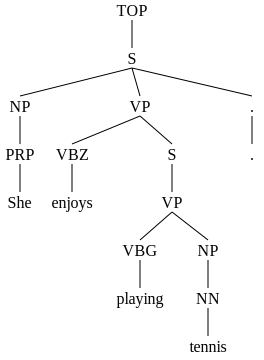

In [35]:
example_tree = nltk.tree.Tree.fromstring("(TOP (S (NP (PRP She)) (VP (VBZ enjoys) (S (VP (VBG playing) (NP (NN tennis))))) (. .)))")
print(example_tree)
example_tree

The approach in this project is to treat parsing as a span classification task. Each span in the sentence (that is, each combination of start and end position) will be assigned a label. Constituents will be labeled with their syntactic category, while non-constituents will recieve a special null label.

In the tree above, "enjoys playing tennis" will be assigned the label "VP", while "She enjoys playing" will be assigned the null label.

However, there is a slight issue applying this to the tree above: the span "playing tennis" is simultaneously a verb phrase (VP) and a nested clause (S). To resolve this issue, we introduce a special chain label "S+VP" for this situation.

The function `collapse_unary_strip_pos` transforms trees to collapse such unary chains. It also strips part-of-speech labels (which can be predicted by the tagger in the previous part of this project), as well as the root label "TOP".

In [36]:
def collapse_unary_strip_pos(tree):
  def strip_pos(tree):
    if len(tree) == 1 and isinstance(tree[0], str):
      return tree[0]
    else:
      return nltk.tree.Tree(tree.label(), [strip_pos(child) for child in tree])
  collapsed_tree = strip_pos(tree)
  collapsed_tree.collapse_unary(collapsePOS=True)
  if collapsed_tree.label() == 'TOP' and len(collapsed_tree) == 1:
    collapsed_tree = collapsed_tree[0]
  return collapsed_tree 

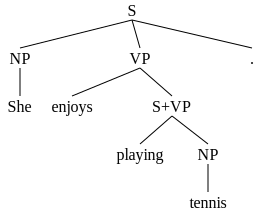

In [37]:
collapsed_tree = collapse_unary_strip_pos(example_tree)
collapsed_tree

Tree objects behaves like lists, in that they can be indexed to produce child nodes. Calling `.label()` returns its label.  If a child is a word instead of a subtree node, it will be a Python string.

Child 0 is: (NP She)


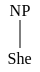

Child 1 is: (VP enjoys (S+VP playing (NP tennis)))


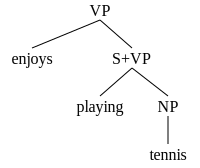

Child 1 label is: VP


In [38]:
print('Child 0 is:', collapsed_tree[0])
display(collapsed_tree[0])
print('Child 1 is:', collapsed_tree[1])
display(collapsed_tree[1])
print('Child 1 label is:', collapsed_tree[1].label())

Your first task for parsing will be to implement an `encode_tree` function that maps from Tree objects to sets of spans with labels and starting/end positions. Since we're using a subword tokenization, the span start/end position will be defined in terms of subword positions. The start position is inclusive and the end is exclusive.  (Note that `▁` is considered part of the span of the following word even if it is not attached.)

Below, we provide an `encode_tree` function that hard-codes the output for our example sentence as an illustration.  We also have code that iterates through the spans returned by `encode_tree` and prints the corresponding fragments from the original tree object.

In [39]:
def encode_tree(tree):
  s = ' '.join(example_tree.leaves())
  if s != 'She enjoys playing tennis .':
    raise NotImplementedError("You should implement encode_tree")
  ids = VOCAB.EncodeAsIds(s)
  word_end_mask = [True, False, True, False, True, False, False, True, True]
  spans = [
      (0, 1, 'NP'), (5, 8, 'NP'), (3, 8, 'S+VP'), (1, 8, 'VP'), (0, 9, 'S')]
  return ids, word_end_mask, spans

['▁She', '▁enjoy', 's', '▁play', 'ing', '▁', 't', 'ennis', '▁.']

NP starting at subword 0 and ending at 1 :



NP starting at subword 5 and ending at 8 :


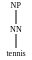


S+VP starting at subword 3 and ending at 8 :


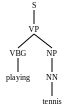


VP starting at subword 1 and ending at 8 :


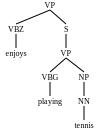


S starting at subword 0 and ending at 9 :


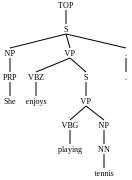

In [40]:
piece_ids, _, spans = encode_tree(example_tree)
print([VOCAB.IdToPiece(piece_id) for piece_id in piece_ids])
print()

subtrees = list(example_tree.subtrees())
for start, end, label in spans:
  s = VOCAB.DecodeIds(piece_ids[start:end])
  for subtree in subtrees:
    if s == ' '.join(subtree.leaves()):
      print(label, 'starting at subword', start, 'and ending at', end, ':')
      display(svgling.draw_tree(subtree, font_size=8))
      print()
      break

Your task is to implement `encode_tree` so that it works for all trees, rather than returning hard-coded results.

In [41]:
# BEGIN SOLUTION
def _convert(tree, leaves, is_word_end, out, start):
    #pass
    if isinstance(tree, str):
        return 1     
    if tree.label() !='TOP':
        tree_spans.append((start, start+len(tree.leaves())-1, tree.label()))
    for subtree in tree:
        start += _convert(subtree, start,tree_spans)
    return len(tree.leaves())
# END SOLUTION
  
def encode_tree(tree):
    """Converts a tree into subword token ids and a list of labeled spans.

    Args:
        tree: an nltk.tree.Tree object

    Returns:
        A tuple (ids, is_word_end, spans)
          ids: a list of token ids in the subword vocabulary
          is_word_end: a list with elements of type bool, where True indicates that
            the word piece at that position is the last within its word.
          spans: a list of tuples of the form (start, end, label), where `start` is
            the position in ids where the span starts, `end` is the ending
            point in the span (exclusive), and `label` is a string indicating
            the syntactic label for the constituent.
    """
    tree = collapse_unary_strip_pos(tree)
    # Implementation tip: it may help to look at encode_sentence, provided earlier
    """YOUR CODE HERE"""

    # BEGIN SOLUTION
    ids, is_word_end = encode_sentence(tree.leaves())
    tree_spans, spans = [], []
    _convert(tree, 0,tree_spans)
    start_end = [0]
    for i in range(len(is_word_end)):
        if is_word_end[i]:
            start_end.append(i+1)   
    spans = [(start_end[s],start_end[t+1], label) for s, t, label in tree_spans]
    return ids,is_word_end,spans
    # END SOLUTION

Here is a simple test that your implementation is correct. The `assert` statement should not produce any errors for a correct implementation.

In [42]:
for tree in READER.parsed_sents('dev'):
  piece_ids, _, spans = encode_tree(tree)
  if UNK_ID in piece_ids:
    continue  # skip verifying this sentence
  span_strs = [VOCAB.DecodeIds(piece_ids[start:end]) for start, end, _ in spans]
  assert set([' '.join(subtree.leaves()) for subtree in tree.subtrees()
              if not isinstance(subtree[0], str)]) == set(span_strs)

TypeError: _convert() missing 2 required positional arguments: 'out' and 'start'

Now we can take inventory of all span labels in the training data. The validation and test sets have a few span labels outside this set because collapsing unary chains creates additional labels, so we also introduce an `UNK` label. Finally, there is a null label to represent that a span is not a syntactic constituent.

In [ ]:
SPAN_LABELS = set()
for tree in READER.parsed_sents('train'):
  _, _, spans = encode_tree(tree)
  for _, _, label in spans:
    SPAN_LABELS.add(label)
SPAN_LABELS = ['', 'UNK'] + sorted(SPAN_LABELS)

# This is another check to ensure that your implementation matches ours.
assert len(SPAN_LABELS) == 114

The implementation of the `ParsingDataset` class below is left for you to complete, based on the requirements of your model. You may wish to refer to the earlier `POSTaggingDataset` when implementing this class.

In [ ]:
class ParsingDataset(torch.utils.data.Dataset):
  def __init__(self, split):
    assert split in ('train', 'dev', 'test')
    self.trees = READER.parsed_sents(split)
    if split == 'train':
      # To speed up training, we only train on short sentences.
      self.trees = [tree for tree in self.trees if len(tree.leaves()) <= 40]

  def __len__(self):
    return len(self.trees)

  def __getitem__(self, index):
    """ This function loads a single tree into tensors for 'ids', 'labels', and
    'is_word_end'.

    See 'collate' function below for a description of the batched version of the
    tensors to return.
    """

    tree = self.trees[index]
    """YOUR CODE HERE"""

    # don't forget to add BOS_ID and EOS_ID to the start and end of the sentence
    
    # note that you will need to check for unknown labels and replace them with
    #  'UNK' (because of unique unary chains in the validation and test sets)

    # use '' (index 0) as the null label for spans that aren't constituents
    # you will need a separate index (such as -1) for positions that should not
    #  receive loss

    # BEGIN SOLUTION
    ids, is_word_end, spans = encode_tree(tree)
    ids = [BOS_ID] + ids + [EOS_ID]
    is_word_end = [False] + is_word_end + [False]
    
    labels = torch.zeros((len(ids), len(ids)), dtype=torch.int64)
    labels[-1,:] = -1
    labels[:,0] = -1
    labels[0,:] = -1
    for i in range(1,len(ids)-1):
        labels[i, :i+1] = -1   
    for s,t, label in spans:
        if label not in SPAN_LABELS:
            label = 'UNK'
        labels[s+1, t+1] = SPAN_LABELS.index(label) 
    
    return {
    'ids': torch.tensor(ids).type(torch.long),
    'labels': labels.type(torch.long),
    'is_word_end': torch.tensor(is_word_end)}
    # END SOLUTION

  @staticmethod
  def collate(batch):
    """ This function takes a list of examples as output by your __getitem__
    function and turns them into batched tensors.
    
    Returns:
      A dictionary with three keys.
      * 'ids' holds a tensor of shape [batch_size, max_sentence_length] and
        dtype torch.long (where max length is taken within this batch).
      * 'labels' is a required feature that's used by our evaluation logic. It
        should be a torch.long tensor of shape
        [batch_size, max_sentence_length, max_sentence_length] with
        labels[batch, i, j] representing the label of the span starting at
        subword position i and ending at subword position j (exclusive).
      * 'is_word_end' is a required feature that's used by our skeleton code.
        It should be a torch.bool tensor of shape [batch_size, max_sentence_length],
        with True values at the last sub-word piece for each word.
    """

    """YOUR CODE HERE"""

    # BEGIN SOLUTION
    all_ids=[each['ids'] for each in batch]
    all_end_pos=[each['is_word_end'] for each in batch]
    ids=pad_sequence(all_ids, batch_first=True, padding_value=PAD_ID)
    is_word_end=pad_sequence(all_end_pos,batch_first=True,padding_value=False)
    max_length=ids.shape[1]
    labels = torch.full((len(batch), max_length, max_length),-1)
    for idx,pair in enumerate(batch):
        b_len = len(pair['ids'])
        labels[idx][:b_len,:b_len]=pair['labels']
    # END SOLUTION

    return {
        'ids': ids.to(device),
        'labels': charts.to(device),
        'is_word_end': is_word_end.to(device),
        }


In [ ]:
dataset_for_inspection = ParsingDataset('train')
print(dataset_for_inspection.trees[0].leaves())
dataset_for_inspection[0]

The cell below sanity-checks your implementation of the `labels` and `is_word_end` features of the dataset. The tests are not exhaustive, but any errors are an indication that you have not constructed the batched examples correctly.

In [ ]:
dataset_for_check = ParsingDataset('dev')
batch_size_for_check = 16
data_loader_for_test = torch.utils.data.DataLoader(
    dataset_for_check, batch_size=batch_size_for_check, shuffle=False,
    collate_fn=dataset_for_check.collate)

for batch_num, batch in enumerate(data_loader_for_test):
  for example_num in range(batch['ids'].shape[0]):
    tree = dataset_for_check.trees[
        batch_size_for_check * batch_num + example_num]
    piece_ids = batch['ids'][example_num].cpu().numpy().tolist()
    labels = batch['labels'][example_num].cpu().numpy()
    is_word_end = batch['is_word_end'][example_num].cpu().numpy()

    if UNK_ID in piece_ids:
      continue  # skip verifying this sentence

    constituents = set([
      ' '.join(subtree.leaves())
      for subtree in tree.subtrees() if not isinstance(subtree[0], str)])
    expected_labels = [
        subtree.label()
        for subtree in collapse_unary_strip_pos(tree).subtrees()]

    labels_from_dataset = []
    for i in range(labels.shape[0]):
      for j in range(labels.shape[1]):
        span_str = VOCAB.DecodeIds(piece_ids[i:j])
        try:
          if not piece_ids[i:j]:
            assert labels[i, j] == -1, (
                'This range is not a span and must have label -1')
          elif (BOS_ID in piece_ids[i:j]
                or EOS_ID in piece_ids[i:j]
                or PAD_ID in piece_ids[i:j]):
            assert labels[i, j] == -1, (
              'This span contains a start, stop, or padding token and must have '
              'label -1')
          elif span_str not in constituents:
            assert labels[i, j] == 0, (
              'This span is not a constituent, but its label is not 0')
          else:
            # The span may be a constituent (or this may be a false positive,
            # because this verification code only looks at string equality)
            assert 0 <= labels[i, j] < len(SPAN_LABELS), (
              'The assigned label is not valid for this span')
            if labels[i, j] != 0:
              labels_from_dataset.append(SPAN_LABELS[labels[i, j]])
          
          if labels[i, j] > 0:
            assert i == 0 or piece_ids[i-1] == BOS_ID or is_word_end[i-1], (
              'This labeled span does not start on a word boundary')
            assert j == 0 or piece_ids[j-1] == BOS_ID or is_word_end[j-1], (
              'This labeled span does not end on a word boundary')
        except AssertionError as e:
          print(f'ERROR at span [i = {i}, j = {j}, label = {labels[i,j]}]')
          print(str(e))
          print()
          for i, (piece_id, is_word_end_bool) in enumerate(zip(piece_ids,
                                                               is_word_end)):
            print('{:2d} {: <10} {}'.format(
                i, "(word end)" if is_word_end_bool else "",
                VOCAB.IdToPiece(piece_id)))
          raise

    assert sorted(expected_labels) == sorted(labels_from_dataset), (
        f'The dataset has {len(labels_from_dataset)} non-empty labels for this '
        f'example, which do not match the {len(expected_labels)} labels in the '
        f'original tree')

## Parsing: Model

Next, you will implement a Transformer-based parsing model. Below is a base class that checks performance on the validation set based on a local decision at each span.  Later, you will implement CKY decoding that ensures the output is a tree rather than a set of possibly-intersecting spans.

In [ ]:
class ParsingModel(nn.Module):
  def encode(self, batch):
    # you will override this below
    raise NotImplementedError()

  def compute_loss(self, batch):
    # you will override this below
    raise NotImplementedError()

  def get_validation_metric(self):
    dataset = ParsingDataset('dev')
    data_loader = torch.utils.data.DataLoader(
      dataset, batch_size=8, collate_fn=dataset.collate)
    self.eval()
    total_gold_spans = 0
    total_predicted_spans = 0
    total_correct = 0
    with torch.no_grad():
      for batch in data_loader:
        mask = (batch['labels'] != -1)
        model_output = self.encode(batch)
        predicted_labels = model_output.argmax(-1)
        predicted_labels = predicted_labels[mask]
        gold_labels = batch['labels'][mask]

        total_gold_spans += (gold_labels != 0).sum().item()
        total_predicted_spans += (predicted_labels != 0).sum().item()
        total_correct += ((predicted_labels == gold_labels) & (gold_labels != 0)
            ).sum().item()

    if total_predicted_spans != 0:
      precision = total_correct / total_predicted_spans
    else:
      precision = 0.0
    recall = total_correct / total_gold_spans
    if precision == 0.0 or recall == 0.0:
      f1 = 0.0
    else:
      f1 = 2 * precision * recall / (precision + recall)
    # For convenience, we represent precion/recall/F1 as percentage points.
    precision *= 100
    recall *= 100
    f1 *= 100
    print(f"precision={precision:.2f} recall={recall:.2f} f1={f1:.2f}")
    return f1

Here is a skeleton for the parsing model that you should fill in. The parser should:
- Run a Transformer encoder to produce a vector at each position in the sentence.
- Compute a vector for each span, by subtracting the vectors for the start and endpoints. You may also try other options, such as adding, averaging, or concatenating.
- Run an MLP span classifier that takes these span vectors as input. The MLP should have one layer of nonlinearity. In our implementation, the MLP also includes a Layer Normalization step.

In [ ]:
class TransformerParsingModel(ParsingModel):
  def __init__(self):
    super().__init__()
    d_model = 256
    self.add_timing = AddPositionalEncoding(d_model)
    self.encoder = TransformerEncoder(d_model)
    """YOUR CODE HERE."""

    # BEGIN SOLUTION
    self.d_mid=512
    self.embed = nn.Embedding(VOCAB.GetPieceSize(), d_model, padding_idx=PAD_ID)
    self.fc1=nn.Linear(d_model,self.d_mid)
    self.out=nn.Linear(self.d_mid,len(SPAN_LABELS))
    self.layer_norm=nn.LayerNorm(self.d_mid)
    self.relu=nn.ReLU()
    self.train_loss=[]
    # END SOLUTION

  def encode(self, batch):
    """Returns logits for each label and each span in the sentence.
    
    Returns:
      A float tensor of shape [batch_size, length, length, len(SPAN_LABELS)],
      where the element at position [n, i, j, l] represents the score (logit) of
      assigning label l to the span beginning at subword position i and ending
      at position j (exclusive), for the n-th example in the batch.
    """

    """YOUR CODE HERE"""

    # You don't need to worry about is_word_end here or in compute_loss
    # You can train with non-end subwords still in place (with null labels) and
    # we'll handle adjusting for subwords for you in the evaluation functions

    # BEGIN SOLUTION
    ids = batch['ids']
    embed=self.embed(ids)
    x=self.add_timing(embed)
    mask = (ids == PAD_ID)
    encoder_output = self.encoder(x,mask)
    sub_x=encoder_output[:,None,:,:]-encoder_output[:,:,None,:]
    output=self.relu(self.fc1(sub_x))
    output=self.layer_norm(output)
    output=self.out(output)
    return output
    # END SOLUTION
  
  def compute_loss(self, batch):
    """This function should compute a cross-entropy loss for training the model.

    Note that labels should be set to -1 wherever there is no classification
    decision to make; for example, due to padding or at positions [..., i, j, :]
    where i >= j (i.e. the supposed start position is equal to or comes after
    the end position).
    """
    logits = self.encode(batch)
    labels = batch['labels']

    """YOUR CODE HERE"""

    # BEGIN SOLUTION
    criterion=nn.CrossEntropyLoss( ignore_index=-1)
    logits = logits.view(-1, logits.shape[-1])
    labels = labels.view(-1)
    loss = criterion(logits, labels)
    return loss
    # END SOLUTION

The code below trains the parser.

In our implementation, it reports a validation score of 66-70 F1 after a single epoch and 80-82 F1 after 5 epochs. If you observe worse performance, we recommend that you debug and adjust your model rather than waiting for the full 16 epochs to complete. When debugging, be sure to also check your Transformer implementation: a buggy version of the Transformer might work for part of speech tagging, but not for the harder task of parsing.

After training completes, our implementation reports 86.4 validation F1. Each epoch takes about 1.5 minutes on a fast GPU instance.

In [ ]:
# You are welcome to adjust these parameters based on your model implementation.
num_epochs = 16
batch_size = 16

parsing_model = TransformerParsingModel().to(device)
train(parsing_model, num_epochs, batch_size, "parsing_model.pt",
      dataset_cls=ParsingDataset)

_We recommend that you download `parsing_model.pt` now in case your runtime gets disconnected._

Having trained a parser, it is now time to have it produce trees. The `predict` function will run your parser on batches from the dataset; however, it requires that you implement the `cky_decode` function a few cells down.

In [ ]:
def predict(parsing_model, split, tagging_model=None):
  assert split in ('dev', 'test')
  if tagging_model is None:
    tagged_sents = READER.tagged_sents(split)
  else:
    tagged_sents = predict_tags(tagging_model, split)
  
  label_scores_charts = predict_span_label_scores(parsing_model, split)

  pred_trees = []
  for tagged_sent, label_scores_chart in zip(tagged_sents, label_scores_charts):
    leaves = [nltk.tree.Tree(tag, [word]) for word, tag in tagged_sent]
    tree = cky_decode(leaves, label_scores_chart)
    tree = uncollapse_tree(tree)
    pred_trees.append(tree)
  return pred_trees


def predict_span_label_scores(parsing_model, split):
  assert split in ('dev', 'test')
  dataset = ParsingDataset(split)
  data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=False, collate_fn=dataset.collate)
  parsing_model.eval()
  all_label_scores_charts = []
  with torch.no_grad():
    for batch in data_loader:
      label_scores_charts = parsing_model.encode(batch)
      label_scores_charts = F.log_softmax(label_scores_charts, dim=-1) # Not necessary, but okay to keep. 
      for i in range(batch['ids'].shape[0]):
        label_scores_chart = label_scores_charts[i]

        # The data pipeline uses is_word_end for consistency with the part of
        # speech tagging models, but here we need is_word_start instead. Note
        # that because span endpoints use exclusive indexing, the index actually
        # points to the first subword in the next word.
        is_word_end = batch['is_word_end'][i]
        is_word_start = F.pad(is_word_end, (1, -1), value=False)
        is_word_start[1] = True

        # Extract scores for whole words only, ignoring any model decisions that
        # have a span start or end halfway through a word. Evaluation for
        # parsing typically uses the ground-truth tokenization from the dataset.
        label_scores_chart = label_scores_chart[
            is_word_start, : ,:][:, is_word_start, :]
        label_scores_chart = label_scores_chart.cpu().numpy()

        all_label_scores_charts.append(label_scores_chart)
  return all_label_scores_charts


def uncollapse_tree(tree):
  if isinstance(tree, str):
    return tree
  else:
    labels = tree.label().split('+')
    children = []
    for child in tree:
      child = uncollapse_tree(child)
      if isinstance(child, str) and (len(tree) > 1
                                     or labels[-1] not in PARTS_OF_SPEECH):
        child = nltk.tree.Tree('UNK', [child])
      children.append(child)
    for label in labels[::-1]:
      children = [nltk.tree.Tree(label, children)]
    return children[0]

The argmax model predictions are not guaranteed to be a valid tree: some of the spans may intersect with one another, which is not allowed in our syntactic formalism. Your next task is to implement CKY decoding, which will be used to find the highest-scoring tree under the model (i.e. the set of span label assignments with highest probability, among all sets where none of the spans intersect).  You can reference the parsing lecture slides if you aren't sure where to start.  Note that the lecture slides CKY required special handling for unary chains, but you will not need to implement this case because we have collapsed all unary chains into a single label.  Also, while traditional CKY had to maximize over production rules (between a span label and its children's labels), here we can maximize over span labels independently because we aren't modeling interactions between adjacent labels.

CKY is designed to handle binary trees, but some productions have greater than two children.  For this project, we will handle non-binary productions by allowing intermediate dummy nodes with a special null label, implemented in the code as an empty string '' at index 0 in SPAN_LABELS.  All non-spans are assigned this label.  You should allow your CKY to select spans with the null label, but then collapse them out when creating the tree.  For example, to create a trinary production "(A  b c d)", CKY would select a tree that looks like "(A  b (null  c d))" or "(A  (null  b c) d)" and then would remove the null nodes to get "(A  b c d)" like we wanted.

You will find that if you allow CKY to select null labels and you directly use log probabilities as the scores, you will often end up with trees made up entirely of null labels.  This happens because many spans have a very high probability assigned to the null label (because they clearly shouldn't be a constituent), and choosing a maximum probability tree will be biased towards selecting these.  To avoid having high-probability null labels competing with non-null labels, we can normalize our scores in a different way: for each span, we will subtract the score (logit) of the null label from the scores of all the labels (both null and non-null).  This will make all null label scores 0, and scale the other label scores of the span appropriately.  This normalization will make it so that if a local span decision would prefer a non-null label it will have positive score, and thus have higher score than all 0-score null labels.  That way, we will prefer to use spans with non-null labels unless they conflict with eachother.

Implementation tip: Don't forget that it is possible for the tree to have labels on spans of length 1.  These labels will go directly above the part of speech label.  Take a look at the example tree at the beginning of "Parsing: Setup", which has a NP span label directly above the NN part-of-speech label.

In [ ]:
def cky_decode(leaves, label_scores_chart):
    """YOUR CODE HERE"""
    # BEGIN SOLUTION
    label_scores_chart -= label_scores_chart[: , : , 0, None]
#     bottom up cyk
    n = len(leaves)
    scores = [[(float('-inf'), None) for _ in range(n + 1)] for _ in range(n + 1)]
#     for leaves
    for i in range(n):
        tag_idx = np.argmax(label_scores_chart[i, i + 1])
        tag = SPAN_LABELS[tag_idx]
        score = label_scores_chart[i, i + 1, tag_idx]
        scores[i][i+1] = (score, nltk.tree.Tree(tag, [leaves[i]]))
    
    for span in range(2, n + 1):
        for i in range(n - span + 1):
            j = i + span
            tag_idx = np.argmax(label_scores_chart[i, j])
            best_tag = SPAN_LABELS[tag_idx]
            best_score, best_tree = scores[i][j]
#             update
            for k in range(i + 1, j):
                left_score, left_tree = scores[i][k]
                right_score, right_tree = scores[k][j]
                score = left_score + right_score + label_scores_chart[i, j, tag_idx]
                if score > best_score:
                    best_score = score
                    scores[i][j] = (best_score,  nltk.tree.Tree(best_tag, [left_tree, right_tree]))

    
    def collapse(tree):
        nodes = []
        if isinstance(tree, str):
            return [tree]
        if tree.label() != SPAN_LABELS[0]:
            for c in tree:
                nodes.extend(collapse(c))
            return [nltk.tree.Tree(tree.label(), nodes)]
        else:
            for c in tree:
                nodes.extend(collapse(c))
            return nodes
        
        
    best_tree = scores[0][n][1]
    best_tree = collapse(best_tree)[0]
    return best_tree
    # END SOLUTION

    if 'you have not implemented this function yet':
        print('Leaves are:')
        print(leaves)
        print('label_scores_chart has the following shape:')
        print(label_scores_chart.shape)
        raise NotImplementedError()

The code below runs the parser on the validation data and displays one of the trees.

In [ ]:
predicted_dev_trees = predict(parsing_model, 'dev')
predicted_dev_trees[6]

## Final evaluation

The standard evaluation for parsing is typically performed using the EVALB software (https://nlp.cs.nyu.edu/evalb/). The F1 score it reports is slightly different than what we reported during training. For one, this score is computed over original spans, without collapsing unary chains. For a constituent to be considered correct, its label must match the ground-truth label. EVALB also ignores punctuation when determining whether spans are correct.

The metrics reported by EVALB include:
- *Bracketing Recall*: Number of correct constituents divided by the number of constituents in the ground-truth data
- *Bracketing Precision*: Number of correct constituents divided by the number of constituents in the predicted trees
- *Bracketing FMeasure*: The F1 score, which is the harmonic mean of the Bracketing Recall and Bracketing Precision
- *Complete Match*: Percentage of sentences where recall and precision are both 100%
- *Average crossing*: Number of constituents crossing a ground-truth constituent divided by the number of sentences
- *No crossing*: Percentage of sentences which have 0 crossing brackets

Metrics are reported both for the full dataset and for the subset of sentences that have length 40 or shorter.

Your model should be able to achieve an F1 score ("Bracketing FMeasure") **above 89.0 for sentences of length 40 or shorter** ("len<=40"). **The autograder will check this number as part of grading.**

In the interest of speed, the code in this project only trains on short sentences, and our recommended hyperparameters keep the model size small. Relaxing these restrictions and training for about a day can give better results, possibly as high as 92 F1 on sentences of all lengths.

In [ ]:
# We first need to compile the EVALB program
!cd EVALB; make 

In [ ]:
with open('./dev_predictions_parser_only.txt', 'w') as f:
  for tree in predicted_dev_trees:
    f.write(' '.join(str(tree).split()) + '\n')

In [ ]:
!EVALB/evalb -p EVALB/nk.prm dev dev_predictions_parser_only.txt | tail -n 29

# Report: Parsing Error Analysis

For this section, you will perform error analysis on your parser. You should aim for no more than 1-page worth of text, but may use more pages to fit any figures and visualizations you deem appropriate. You may use any editor you like, but we recommend using LaTeX and working in an environment like Overleaf. 

You are free to decide on what analysis to perform. Your analysis should dive into the details of an aspect of the model's behavior beyond just reporting its evaluation performance from EVALB. Some examples of what you could do: 

* Analyze precision-recall curves, training graphs, or other experimental statistics. 
* Comparison of model performance across word categories or sentence types (e.g. NP vs VP), accompanied by appropriate statistics. 
* A qualitative analysis of how your model resolves instances of structural ambiguity in sentences you write (https://allthingslinguistic.com/post/52411342274/how-many-meanings-can-you-get-for-the-sentence-i).
* etc.

For full credit, your report should include the following: 
1. An in depth analysis of your choice into an aspect of the model's parsing behavior. 
2. Figures supporting your analysis, e.g. plots, tables, parse trees predicted by your model and ground-truth trees from the development set, etc. 

When you submit the report, name it **report.pdf**. 

## Submission

Your submission should consist of your code, as well as parsing and tagging predictions for both validation and test data. Turn in the following files on Gradescope:
* hw3.ipynb (this file; please rename to match)
* dev_predictions_tagger_only.txt
* dev_spans.txt
* dev_predictions_parser_only.txt
* test_predictions.txt
* report.pdf

Here, the `predict` function runs both the tagger and the parser, combining their results into a single tree object. The predicted trees are saved as text files, with one line per tree.

Be sure to check the output of the autograder after it runs.  It should confirm that no files are missing and that the output files have the correct format.

In [ ]:
# Uncomment this code to restore models from a checkpoint.
#
# tagging_model = TransformerPOSTaggingModel().to(device)
# tagging_model.load_state_dict(torch.load('tagging_model.pt'))
# parsing_model = TransformerParsingModel().to(device)
# parsing_model.load_state_dict(torch.load('parsing_model.pt'))

with open('./dev_predictions_tagger_only.txt', 'w') as f:
  for tagged_sent in predict_tags(tagging_model, 'dev'):
    leaves = [nltk.tree.Tree(tag, [word]) for word, tag in tagged_sent]
    dummy_tree = nltk.tree.Tree('TOP', leaves)
    f.write(' '.join(str(dummy_tree).split()) + '\n')

with open('./dev_spans.txt', 'w') as f:
  for n, chart in enumerate(predict_span_label_scores(parsing_model, 'dev')):
    chart = np.argmax(chart, -1)
    for i in range(chart.shape[0]):
      for j in range(i+1, chart.shape[1]):
        if chart[i, j] > 0:
          f.write(f'{n} {i} {j} {SPAN_LABELS[chart[i, j]]}\n')

with open('./dev_predictions_parser_only.txt', 'w') as f:
  for tree in predict(parsing_model, 'dev'):
    f.write(' '.join(str(tree).split()) + '\n')

with open('./test_predictions.txt', 'w') as f:
  for tree in predict(parsing_model, 'test', tagging_model=tagging_model):
    f.write(' '.join(str(tree).split()) + '\n')

For full credit on the tagging portion:
- `dev_tagging_accuracy` must exceed 95
- `test_tagging_accuracy` should exceed 94

For full credit on the parsing portion:
- `dev_f1` must exceed 89
- `test_f1` should exceed 88

For partial credit on the parsing portion, due to not having implemented CKY:
- `dev_f1_no_cky` should exceed 86
